## Test Temporal Fusion Transformers V3

Using device: cpu


/var/folders/31/b1v52j156gbfz83pmrnth3jc0000gn/T/ipykernel_66521/866140032.py:184: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')


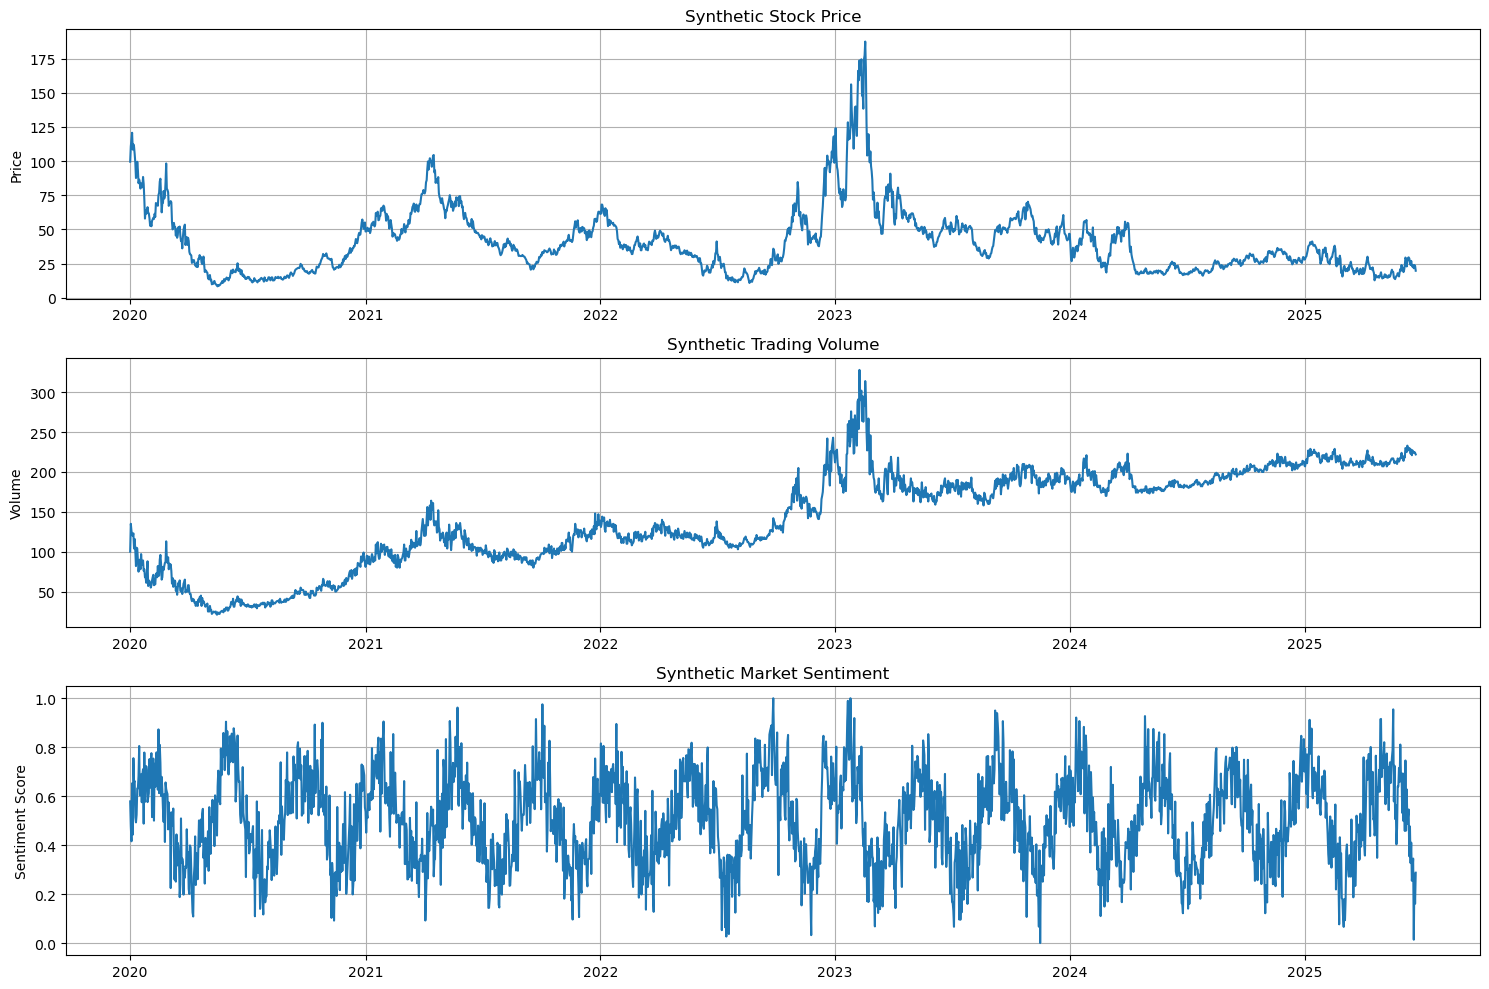

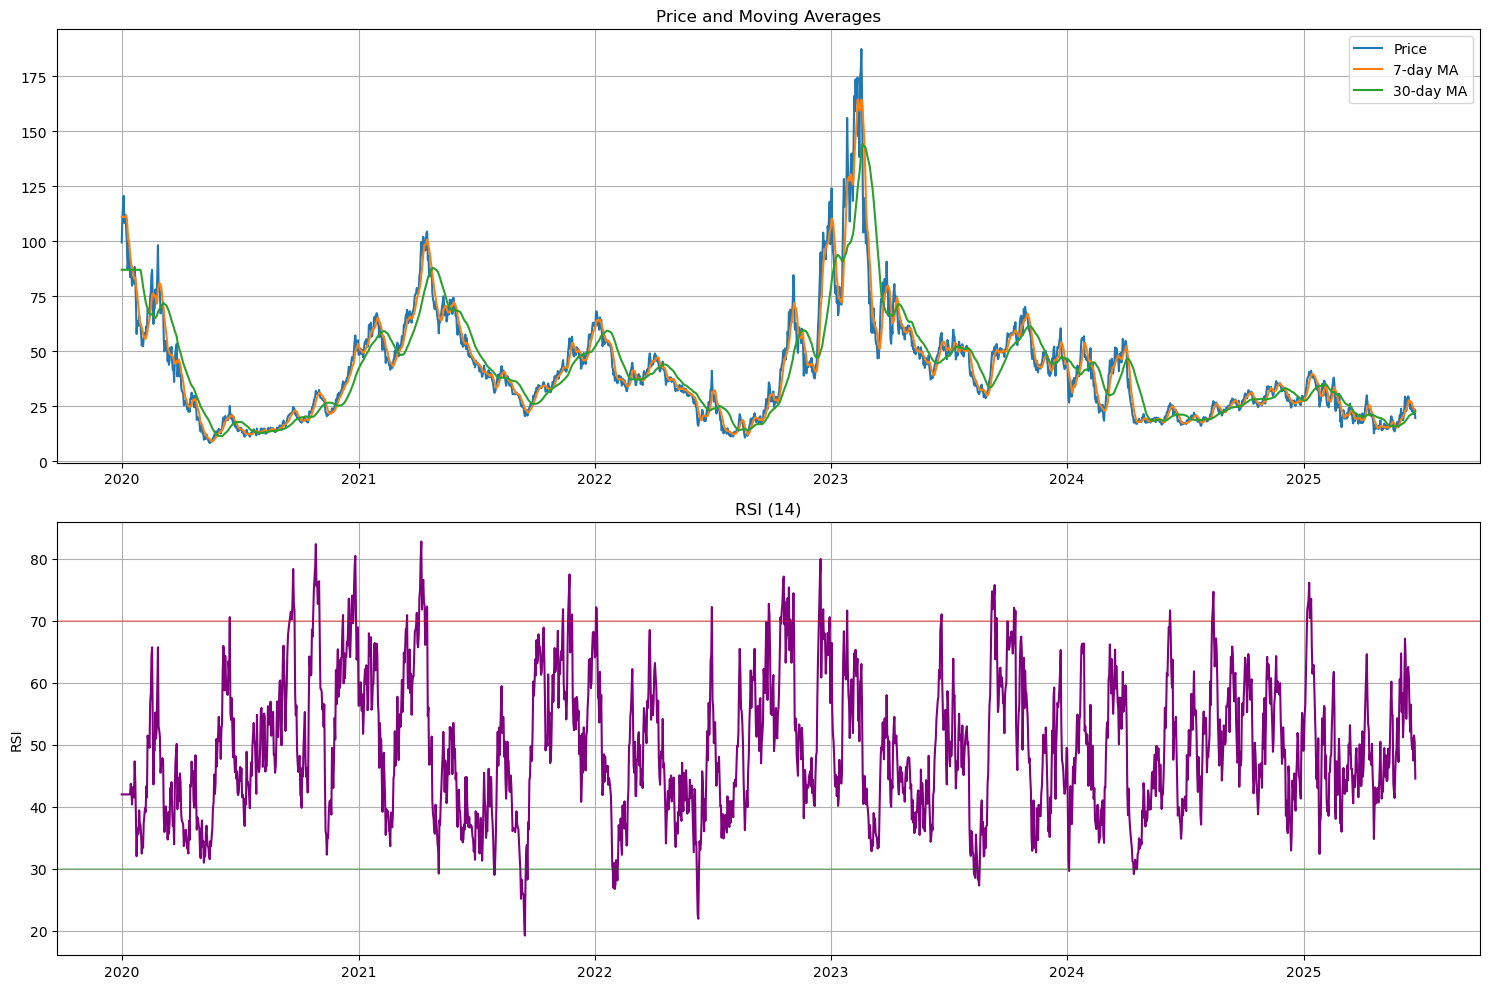

Train data shape: torch.Size([1571, 7])
Test data shape: torch.Size([393, 7])
Encoder input 0 shape: torch.Size([1571, 30, 6])
Encoder input 1 shape: torch.Size([1571, 30, 18])
Decoder input 0 shape: torch.Size([1571, 7, 6])


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from datetime import datetime, timedelta

# Import our TFT implementation
# Assuming you saved the TFT code in a file called temporal_fusion_transformer.py
from models.tft_v3 import TemporalFusionTransformer

# ====================== Set Random Seeds for Reproducibility ======================
# IMPORTANT: Change these seed values to generate different datasets
RANDOM_SEED = 88  # Master seed for overall reproducibility
# REGIME_SEED = 123  # Controls market regime changes
# EVENT_SEED = 456  # Controls random events/jumps
# NOISE_SEED = 789  # Controls daily price noise

# Example seed combinations for different dataset characteristics:

# More balanced regimes with moderate volatility
# REGIME_SEED = 456
# EVENT_SEED = 789
# NOISE_SEED = 101

# Bearish early, bullish late dataset
# REGIME_SEED = 222
# EVENT_SEED = 333
# NOISE_SEED = 444

# Highly volatile dataset
REGIME_SEED = 555
EVENT_SEED = 666 
NOISE_SEED = 777

# Set seeds
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ====================== 1. Generate Synthetic Financial Data ======================

def generate_synthetic_financial_data(n_samples=2000, start_date="2020-01-01", 
                                     regime_seed=REGIME_SEED, 
                                     event_seed=EVENT_SEED,
                                     noise_seed=NOISE_SEED):
    """
    Generate synthetic stock price data with market regimes, trends, seasonality, and events.
    
    Args:
        n_samples: Number of days to generate
        start_date: Starting date for the time series
        regime_seed: Seed controlling market regime transitions (bull/bear/sideways)
        event_seed: Seed controlling random price events/jumps
        noise_seed: Seed controlling daily price noise
    """
    dates = pd.date_range(start=start_date, periods=n_samples)
    t = np.arange(n_samples)
    
    # Set regime seed for regime-related randomness
    regime_rng = np.random.RandomState(regime_seed)
    
    # Generate market regimes (bull, bear, sideways)
    regime_changes = np.sort(regime_rng.choice(range(100, n_samples-100), size=6, replace=False))
    regimes = np.zeros(n_samples)
    
    current_regime = regime_rng.choice([0, 1, 2])  # 0=bull, 1=bear, 2=sideways
    for i in range(len(regime_changes) + 1):
        start_idx = 0 if i == 0 else regime_changes[i-1]
        end_idx = n_samples if i == len(regime_changes) else regime_changes[i]
        regimes[start_idx:end_idx] = current_regime
        current_regime = (current_regime + regime_rng.choice([1, 2])) % 3
    
    # Base price with trend dependent on regime
    price = 100 * np.ones(n_samples)
    for i in range(1, n_samples):
        if regimes[i] == 0:  # Bull
            drift = 0.08  # Positive trend
            vol = 1.0
        elif regimes[i] == 1:  # Bear
            drift = -0.05  # Negative trend
            vol = 1.8
        else:  # Sideways
            drift = 0.01
            vol = 0.8
            
        price[i] = price[i-1] * (1 + regime_rng.normal(drift/252, vol/np.sqrt(252)))
    
    # Set event seed for event-related randomness
    event_rng = np.random.RandomState(event_seed)
    
    # Add weekly seasonality (5-day pattern)
    weekly = 0.005 * price * np.sin(2 * np.pi * t / 5)
    
    # Add monthly seasonality
    monthly = 0.02 * price * np.sin(2 * np.pi * t / 30)
    
    # Add quarterly seasonality
    quarterly = 0.05 * price * np.sin(2 * np.pi * t / 90)
    
    # Random events (occasional price jumps with mean reversion)
    events = np.zeros(n_samples)
    event_indices = event_rng.choice(range(n_samples), size=int(n_samples * 0.03), replace=False)
    for idx in event_indices:
        jump_size = event_rng.normal(0, 0.03)
        events[idx] = jump_size * price[idx]
        # Add mean reversion after jumps
        reversion_length = min(7, n_samples - idx - 1)
        reversion = np.linspace(jump_size, 0, reversion_length+2)[1:-1]
        events[idx:idx+reversion_length] += price[idx] * reversion
    
    # Set noise seed for daily noise
    noise_rng = np.random.RandomState(noise_seed)
    
    # Daily noise
    noise = noise_rng.normal(0, 0.01, n_samples) * price
    
    # Combine components
    price = price + weekly + monthly + quarterly + events + noise
    
    # Create dataframe
    df = pd.DataFrame({
        'date': dates,
        'price': price,
        'regime': regimes,
        'day_of_week': dates.dayofweek,
        'day_of_month': dates.day,
        'month': dates.month,
        'is_quarter_end': dates.is_quarter_end.astype(int),
        'is_month_end': dates.is_month_end.astype(int),
        'year': dates.year
    })
    
    # Add technical indicators
    df['ma7'] = df['price'].rolling(window=7).mean()
    df['ma30'] = df['price'].rolling(window=30).mean()
    df['std7'] = df['price'].rolling(window=7).std()
    df['std30'] = df['price'].rolling(window=30).std()
    df['rsi'] = compute_rsi(df['price'], 14)
    
    # Add price momentum features
    for window in [1, 3, 7, 14, 30]:
        df[f'return_{window}d'] = df['price'].pct_change(window)
    
    # Add Bollinger Bands
    df['bb_upper'] = df['ma30'] + 2 * df['std30']
    df['bb_lower'] = df['ma30'] - 2 * df['std30']
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['ma30']
    
    # Add synthetic trading volume (correlated with volatility)
    volume_base = price * (1 + 0.5 * df['std7'].fillna(0) / df['price'])
    volume_trend = 0.1 * t
    volume_noise = np.random.normal(0, price * 0.1, n_samples)
    df['volume'] = volume_base + volume_trend + volume_noise
    # Make sure there are no NaN or inf values before converting to int
    df['volume'] = df['volume'].fillna(0).replace([np.inf, -np.inf], 0).astype(int)

    # Add volume momentum (after making sure volume has no NaNs)
    df['volume_ma7'] = df['volume'].rolling(window=7).mean()
    df['volume_ratio'] = df['volume'] / df['volume_ma7'].replace(0, 1)  # Avoid division by zero
    
    # Add synthetic sentiment data
    sentiment_base = 0.5 + 0.2 * np.sin(2 * np.pi * t / 120)
    # Make sentiment react to price changes
    sentiment_price_effect = 0.3 * df['return_7d'].fillna(0)
    sentiment_noise = np.random.normal(0, 0.1, n_samples)
    df['sentiment'] = np.clip(sentiment_base + sentiment_price_effect + sentiment_noise, 0, 1)
    
    # Add cyclical encoding for time features
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Fill NaN values
    df = df.fillna(method='bfill')
    
    return df

def compute_rsi(prices, window=14):
    """Compute Relative Strength Index."""
    deltas = np.diff(prices)
    seed = deltas[:window+1]
    up = seed[seed >= 0].sum()/window
    down = -seed[seed < 0].sum()/window
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:window] = 100. - 100./(1. + rs)
    
    for i in range(window, len(prices)):
        delta = deltas[i-1]
        if delta > 0:
            upval = delta
            downval = 0
        else:
            upval = 0
            downval = -delta
            
        up = (up * (window - 1) + upval) / window
        down = (down * (window - 1) + downval) / window
        rs = up/down
        rsi[i] = 100. - 100./(1. + rs)
        
    return rsi

# Generate data
df = generate_synthetic_financial_data(n_samples=2000)

# Visualize the generated data
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df['date'], df['price'])
plt.title('Synthetic Stock Price')
plt.ylabel('Price')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(df['date'], df['volume'])
plt.title('Synthetic Trading Volume')
plt.ylabel('Volume')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(df['date'], df['sentiment'])
plt.title('Synthetic Market Sentiment')
plt.ylabel('Sentiment Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# Show technical indicators
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df['date'], df['price'], label='Price')
plt.plot(df['date'], df['ma7'], label='7-day MA')
plt.plot(df['date'], df['ma30'], label='30-day MA')
plt.title('Price and Moving Averages')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df['date'], df['rsi'], color='purple')
plt.axhline(y=70, color='r', linestyle='-', alpha=0.3)
plt.axhline(y=30, color='g', linestyle='-', alpha=0.3)
plt.title('RSI (14)')
plt.ylabel('RSI')
plt.grid(True)

plt.tight_layout()
plt.show()

# ====================== 2. Prepare Data for TFT ======================

# Setting up the forecast parameters
backcast_length = 30  # Number of past time steps to use
forecast_horizon = 7  # Number of future time steps to predict

def prepare_tft_data(df, backcast_length, forecast_horizon):
    """Prepare data for TFT model with enhanced features"""
    data_df = df.copy()
    
    # Feature columns with new additions
    price_cols = ['price']
    
    technical_cols = [
        'ma7', 'ma30', 'std7', 'std30', 'rsi', 
        'bb_upper', 'bb_lower', 'bb_width',
        'return_1d', 'return_3d', 'return_7d', 'return_14d', 'return_30d'
    ]
    
    volume_cols = ['volume', 'volume_ma7', 'volume_ratio']
    sentiment_cols = ['sentiment']
    
    # Enhanced time features using cyclical encoding
    calendar_cols = [
        'day_of_week_sin', 'day_of_week_cos', 
        'month_sin', 'month_cos',
        'is_quarter_end', 'is_month_end'
    ]
    
    # Rest of your preparation function remains the same...
    
    # Normalize the data using StandardScaler
    scalers = {}
    for col in price_cols + technical_cols + volume_cols + sentiment_cols:
        scaler = StandardScaler()
        data_df[f'{col}_scaled'] = scaler.fit_transform(data_df[[col]])
        scalers[col] = scaler
    
    # One-hot encode categorical features
    calendar_cols_encoded = []
    for col in calendar_cols:
        if col in ['day_of_week', 'month']:
            dummies = pd.get_dummies(data_df[col], prefix=col)
            data_df = pd.concat([data_df, dummies], axis=1)
            calendar_cols_encoded.extend(dummies.columns)
        else:
            calendar_cols_encoded.append(col)
    
    # Define dataset
    price_cols_scaled = [f'{col}_scaled' for col in price_cols]
    technical_cols_scaled = [f'{col}_scaled' for col in technical_cols]
    volume_cols_scaled = [f'{col}_scaled' for col in volume_cols]
    sentiment_cols_scaled = [f'{col}_scaled' for col in sentiment_cols]
    
    # Features for the model
    static_features = []  # No static features for this example
    
    # Past inputs
    encoder_time_varying_known = calendar_cols_encoded  # Calendar features we know for the past
    encoder_time_varying_unknown = price_cols_scaled + technical_cols_scaled + volume_cols_scaled + sentiment_cols_scaled
    
    # Future inputs
    decoder_time_varying_known = calendar_cols_encoded  # Calendar features we know for the future 
    decoder_time_varying_unknown = []  # We don't know future price, volume, etc.
    
    # Prepare the dataset - creating windows
    samples = len(data_df) - backcast_length - forecast_horizon + 1
    
    # Initialize arrays directly with proper shapes
    # For encoder inputs
    enc_known = np.zeros((samples, backcast_length, len(encoder_time_varying_known))) if encoder_time_varying_known else []
    enc_unknown = np.zeros((samples, backcast_length, len(encoder_time_varying_unknown))) if encoder_time_varying_unknown else []
    
    # For decoder inputs
    dec_known = np.zeros((samples, forecast_horizon, len(decoder_time_varying_known))) if decoder_time_varying_known else []
    
    # For target
    targets = np.zeros((samples, forecast_horizon))
    
    # Fill the arrays
    for i in range(samples):
        if encoder_time_varying_known:
            enc_known[i] = data_df.iloc[i:i+backcast_length][encoder_time_varying_known].values
            
        if encoder_time_varying_unknown:
            enc_unknown[i] = data_df.iloc[i:i+backcast_length][encoder_time_varying_unknown].values
            
        if decoder_time_varying_known:
            dec_known[i] = data_df.iloc[i+backcast_length:i+backcast_length+forecast_horizon][decoder_time_varying_known].values
            
        targets[i] = data_df.iloc[i+backcast_length:i+backcast_length+forecast_horizon]['price_scaled'].values
    
    # Convert to tensors
    X_static = []  # Empty since we have no static features
    
    # Convert encoder inputs to tensors
    X_encoder = []
    if len(enc_known) > 0:
        X_encoder.append(torch.FloatTensor(enc_known))
    if len(enc_unknown) > 0:
        X_encoder.append(torch.FloatTensor(enc_unknown))
    
    # Convert decoder inputs to tensors
    X_decoder = []
    if len(dec_known) > 0:
        X_decoder.append(torch.FloatTensor(dec_known))
    
    # Convert target to tensor
    y = torch.FloatTensor(targets)
    
    return X_static, X_encoder, X_decoder, y, scalers

# Prepare the data
X_static, X_encoder, X_decoder, y, scalers = prepare_tft_data(df, backcast_length, forecast_horizon)

# Split the data into train and test sets
train_size = int(0.8 * len(y))

# Handle X_static based on whether it's empty
if X_static:
    X_static_train, X_static_test = [x[:train_size] for x in X_static], [x[train_size:] for x in X_static]
else:
    X_static_train, X_static_test = [], []

X_encoder_train = [x[:train_size] for x in X_encoder]
X_encoder_test = [x[train_size:] for x in X_encoder]
X_decoder_train = [x[:train_size] for x in X_decoder]
X_decoder_test = [x[train_size:] for x in X_decoder]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train data shape: {y_train.shape}")
print(f"Test data shape: {y_test.shape}")

# Display data shapes
for i, tensor in enumerate(X_encoder_train):
    print(f"Encoder input {i} shape: {tensor.shape}")
for i, tensor in enumerate(X_decoder_train):
    print(f"Decoder input {i} shape: {tensor.shape}")



In [8]:
# Check dimensions
print("Encoder input dimensions:")
for i, tensor in enumerate(X_encoder_train):
    print(f"Encoder input {i} shape: {tensor.shape}")

print("Decoder input dimensions:")
for i, tensor in enumerate(X_decoder_train):
    print(f"Decoder input {i} shape: {tensor.shape}")

Encoder input dimensions:
Encoder input 0 shape: torch.Size([1571, 30, 6])
Encoder input 1 shape: torch.Size([1571, 30, 18])
Decoder input dimensions:
Decoder input 0 shape: torch.Size([1571, 7, 6])


Model initialized successfully on cpu
Training set size: 1257
Validation set size: 314


/opt/anaconda3/envs/finance/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Loss: 0.2184, Val Loss: 0.1984, MSE: 0.3958, MAE: 0.5226, R²: -0.3261
Epoch [2/50], Train Loss: 0.1192, Val Loss: 0.3040, MSE: 0.8672, MAE: 0.7858, R²: -1.9052
Epoch [3/50], Train Loss: 0.0959, Val Loss: 0.2943, MSE: 1.0224, MAE: 0.8146, R²: -2.4253
Epoch [4/50], Train Loss: 0.0778, Val Loss: 0.3121, MSE: 1.3512, MAE: 0.8800, R²: -3.5268
Epoch [5/50], Train Loss: 0.0696, Val Loss: 0.2817, MSE: 1.0911, MAE: 0.7843, R²: -2.6553
Epoch [6/50], Train Loss: 0.0658, Val Loss: 0.2874, MSE: 1.1857, MAE: 0.8194, R²: -2.9723
Epoch [7/50], Train Loss: 0.0624, Val Loss: 0.3024, MSE: 1.1264, MAE: 0.8166, R²: -2.7737
Epoch [8/50], Train Loss: 0.0588, Val Loss: 0.3041, MSE: 1.0703, MAE: 0.7990, R²: -2.5857
Epoch [9/50], Train Loss: 0.0577, Val Loss: 0.3043, MSE: 1.0584, MAE: 0.7876, R²: -2.5457
Epoch [10/50], Train Loss: 0.0542, Val Loss: 0.3385, MSE: 1.2806, MAE: 0.8618, R²: -3.2903
Analyzing attention weights...
Decoder-Encoder attention shape: torch.Size([5, 4, 7, 30])
Attention

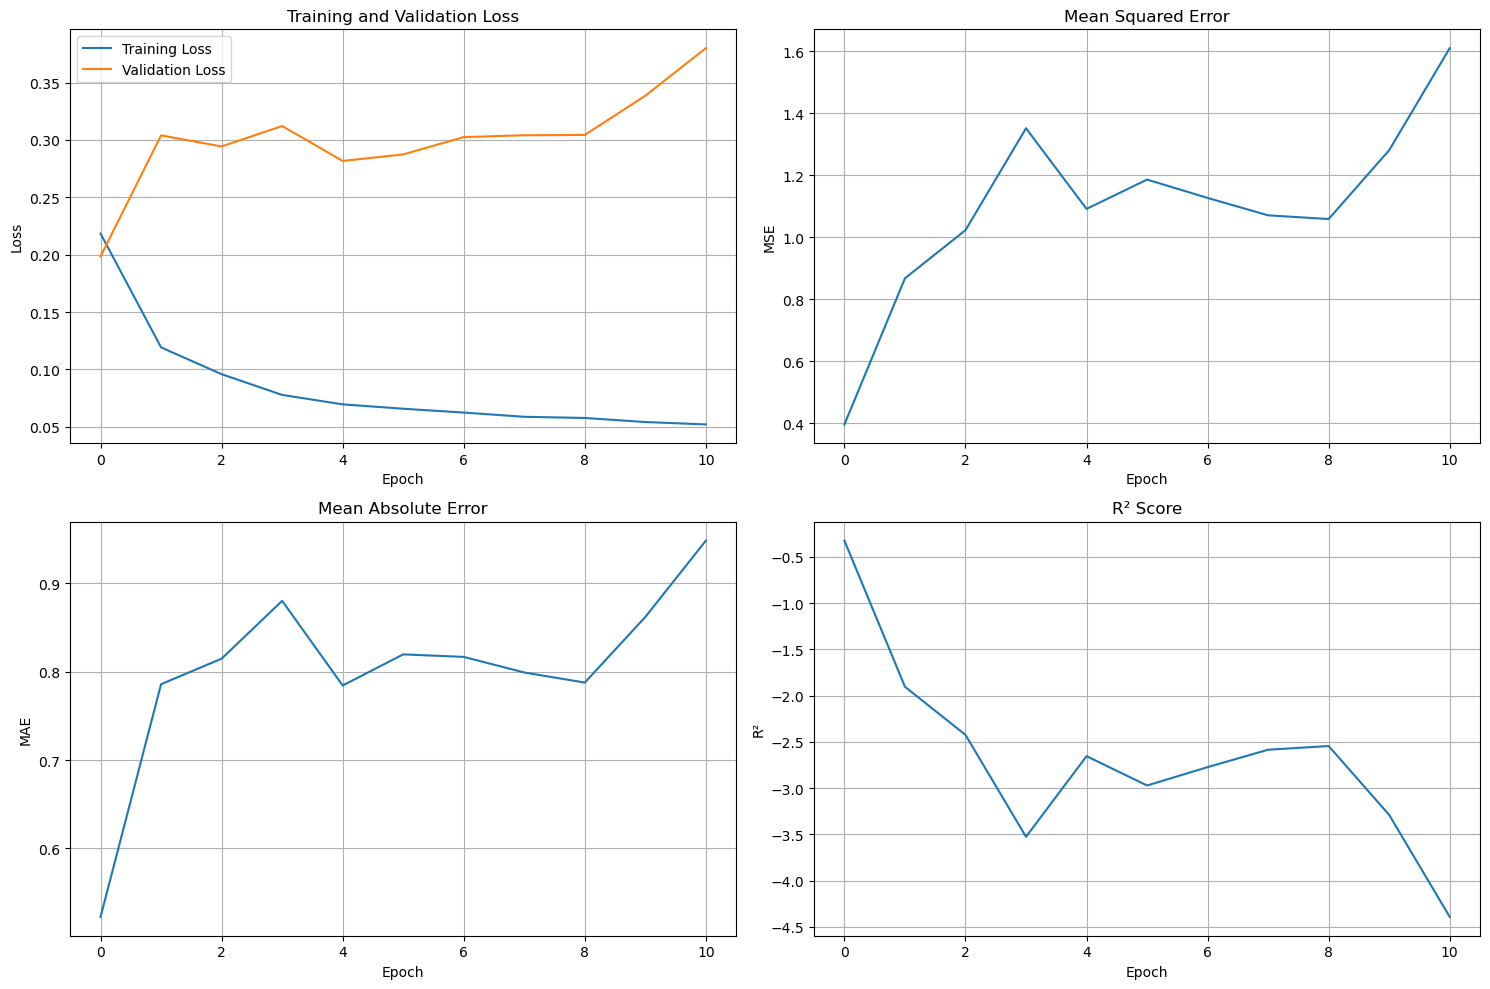

In [9]:
# ====================== 3. Define and Train the TFT Model ======================

# Model parameters
hidden_dim = 64
lstm_layers = 2
num_heads = 4
dropout = 0.1
batch_size = 64
learning_rate = 0.001
num_epochs = 50

# Define the TFT model with correct input sizes based on actual data
model = TemporalFusionTransformer(
    static_input_sizes=[],  # No static inputs
    encoder_input_sizes=[6, 18],  # Actual dimensions from your encoder inputs
    decoder_input_sizes=[6],  # Actual dimensions from your decoder inputs
    hidden_dim=hidden_dim,
    lstm_layers=lstm_layers,
    lstm_dropout=dropout,
    dropout=dropout,
    num_heads=num_heads,
    forecast_horizon=forecast_horizon,
    backcast_length=backcast_length,
    output_dim=1,  # Predicting one value (price)
    quantiles=[0.1, 0.5, 0.9]  # For uncertainty estimation
).to(device)

print(f"Model initialized successfully on {device}")

# Loss function for quantile regression
def quantile_loss(y_pred, y_true, quantiles):
    """
    Calculate quantile loss for multiple quantiles
    """
    losses = []
    for i, q in enumerate(quantiles):
        errors = y_true - y_pred[..., i]
        losses.append(torch.max((q - 1) * errors, q * errors).mean())
    return torch.mean(torch.stack(losses))

# Training function with validation metrics and attention weights
def train_tft_model(model, X_encoder_train, X_decoder_train, y_train,
                   X_encoder_val, X_decoder_val, y_val,
                   num_epochs, batch_size, learning_rate, 
                   quantiles=[0.1, 0.5, 0.9], early_stopping_patience=10):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                    factor=0.5, patience=5, verbose=True)
    
    train_losses = []
    val_losses = []
    val_metrics = {'mse': [], 'mae': [], 'r2': []}
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_weights = None
    
    # Create DataLoader for training
    dataset_size = len(y_train)
    indices = list(range(dataset_size))

    # Create validation DataLoader with fixed batches
    val_dataset_size = len(y_val)
    val_indices = list(range(val_dataset_size))
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        np.random.shuffle(indices)
        epoch_loss = 0
        
        for i in range(0, dataset_size, batch_size):
            batch_indices = indices[i:min(i + batch_size, dataset_size)]
            
            # Prepare batch
            batch_X_encoder = [x[batch_indices].to(device) for x in X_encoder_train]
            batch_X_decoder = [x[batch_indices].to(device) for x in X_decoder_train]
            batch_y = y_train[batch_indices].to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(
                static_inputs=None,  # No static inputs
                encoder_inputs=batch_X_encoder, 
                decoder_inputs=batch_X_decoder
            )
            
            # Calculate loss
            loss = quantile_loss(outputs, batch_y.unsqueeze(-1), quantiles)
            
            # Backward and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Add gradient clipping
            optimizer.step()
            
            epoch_loss += loss.item() * len(batch_indices)
        
        # Average loss for the epoch
        epoch_loss /= dataset_size
        train_losses.append(epoch_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for i in range(0, val_dataset_size, batch_size):
                batch_indices = val_indices[i:min(i + batch_size, val_dataset_size)]
                
                # Prepare batch
                batch_X_encoder = [x[batch_indices].to(device) for x in X_encoder_val]
                batch_X_decoder = [x[batch_indices].to(device) for x in X_decoder_val]
                batch_y = y_val[batch_indices].to(device)
                
                # Forward pass
                outputs = model(
                    static_inputs=None,  # No static inputs
                    encoder_inputs=batch_X_encoder, 
                    decoder_inputs=batch_X_decoder
                )
                
                # Store predictions and targets for metric calculation
                all_preds.append(outputs[:, :, 0, 1].cpu().numpy())  # Median prediction (0.5 quantile)
                all_targets.append(batch_y.cpu().numpy())
                
                # Calculate loss
                loss = quantile_loss(outputs, batch_y.unsqueeze(-1), quantiles)
                val_loss += loss.item() * len(batch_indices)
        
        # Combine predictions and targets
        all_preds = np.concatenate([p.reshape(-1) for p in all_preds])
        all_targets = np.concatenate([t.reshape(-1) for t in all_targets])
        
        # Calculate metrics
        mse = mean_squared_error(all_targets, all_preds)
        mae = mean_absolute_error(all_targets, all_preds)
        r2 = r2_score(all_targets, all_preds)
        
        # Store metrics
        val_metrics['mse'].append(mse)
        val_metrics['mae'].append(mae)
        val_metrics['r2'].append(r2)
        
        # Average validation loss
        val_loss /= val_dataset_size
        val_losses.append(val_loss)
        
        # Update learning rate scheduler
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_weights = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

        # Sample attention weights every 10 epochs
        if (epoch + 1) % 10 == 0:
            print("Analyzing attention weights...")
            # Get a sample batch with attention weights
            sample_indices = val_indices[:min(5, val_dataset_size)]
            sample_X_encoder = [x[sample_indices].to(device) for x in X_encoder_val]
            sample_X_decoder = [x[sample_indices].to(device) for x in X_decoder_val]
            
            with torch.no_grad():
                _, attention_outputs = model(
                    static_inputs=None,
                    encoder_inputs=sample_X_encoder,
                    decoder_inputs=sample_X_decoder,
                    return_attention=True
                )
                
                # Print encoder-decoder attention (most important for interpretability)
                if 'decoder_encoder_attention' in attention_outputs:
                    dec_enc_attn = attention_outputs['decoder_encoder_attention']
                    print(f"Decoder-Encoder attention shape: {dec_enc_attn.shape}")
                    print(f"Attention stats - Min: {dec_enc_attn.min().item():.4f}, "
                          f"Max: {dec_enc_attn.max().item():.4f}, "
                          f"Mean: {dec_enc_attn.mean().item():.4f}")
    
    # Load best model if early stopping was triggered
    if best_model_weights is not None and patience_counter >= early_stopping_patience:
        model.load_state_dict(best_model_weights)
    
    return model, train_losses, val_losses, val_metrics

# Split validation set from training set
val_size = int(0.2 * len(X_encoder_train[0]))
X_encoder_val = [x[-val_size:] for x in X_encoder_train]
X_decoder_val = [x[-val_size:] for x in X_decoder_train]
y_val = y_train[-val_size:]

X_encoder_train = [x[:-val_size] for x in X_encoder_train]
X_decoder_train = [x[:-val_size] for x in X_decoder_train]
y_train = y_train[:-val_size]

print(f"Training set size: {len(y_train)}")
print(f"Validation set size: {len(y_val)}")

# Train the model
model, train_losses, val_losses, val_metrics = train_tft_model(
    model, X_encoder_train, X_decoder_train, y_train,
    X_encoder_val, X_decoder_val, y_val,
    num_epochs, batch_size, learning_rate, 
    early_stopping_patience=10
)

# Plot training and validation loss
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(val_metrics['mse'], label='MSE')
plt.title('Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(val_metrics['mae'], label='MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(val_metrics['r2'], label='R²')
plt.title('R² Score')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.grid(True)

plt.tight_layout()
plt.show()

Training MSE: 56.7757
Training RMSE: 7.5350
Training MAE: 4.3932
Training MAPE: 9.5194%
Training R²: 0.9204
Test MSE: 1198.0021
Test RMSE: 34.6122
Test MAE: 28.7429
Test MAPE: 116.0054%
Test R²: -30.2540


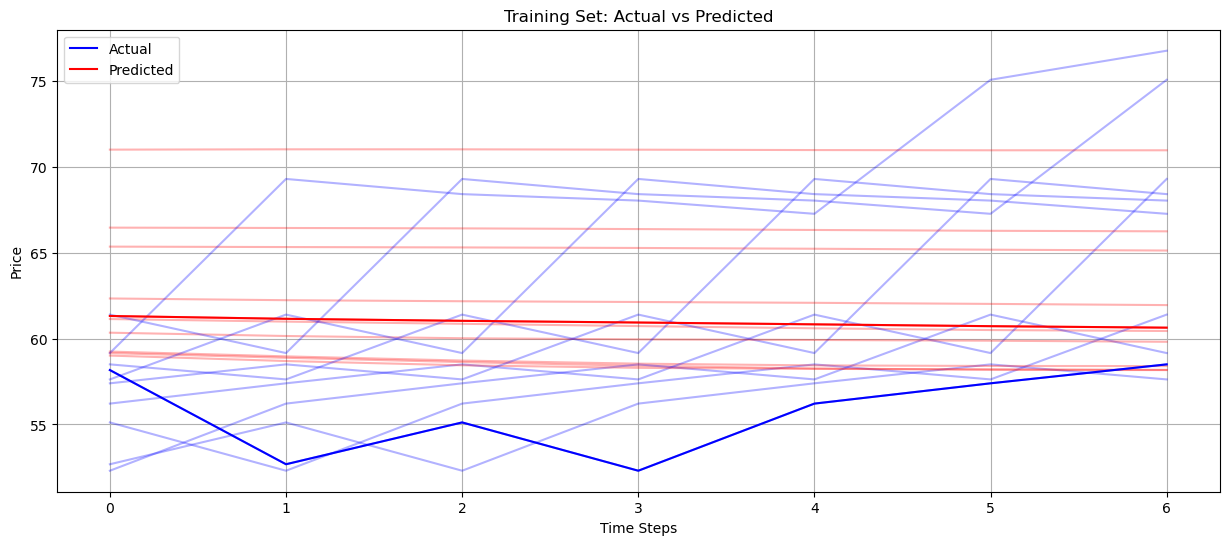

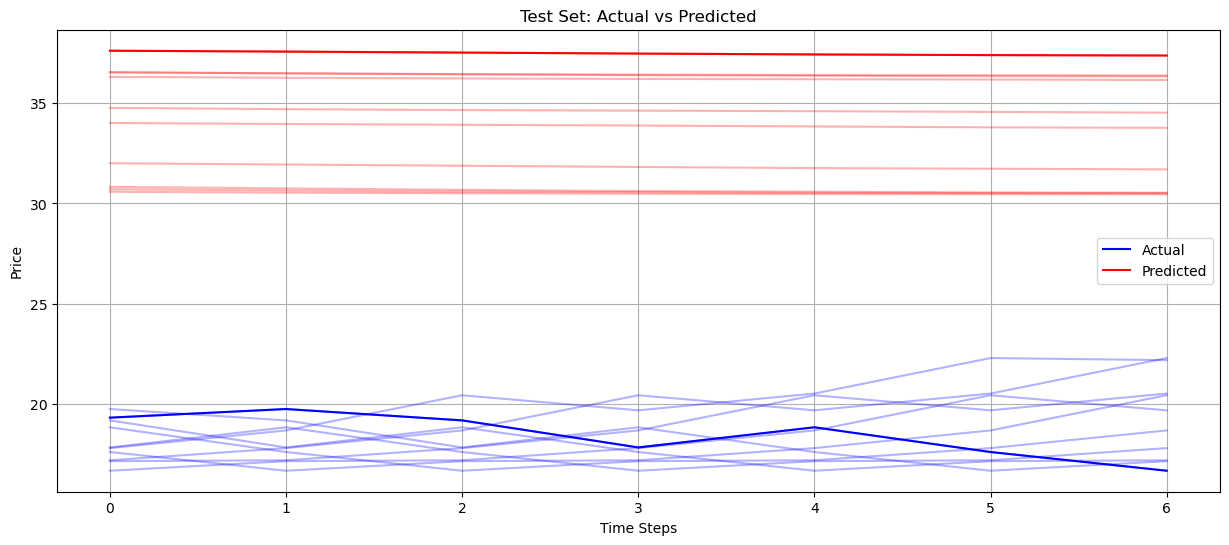

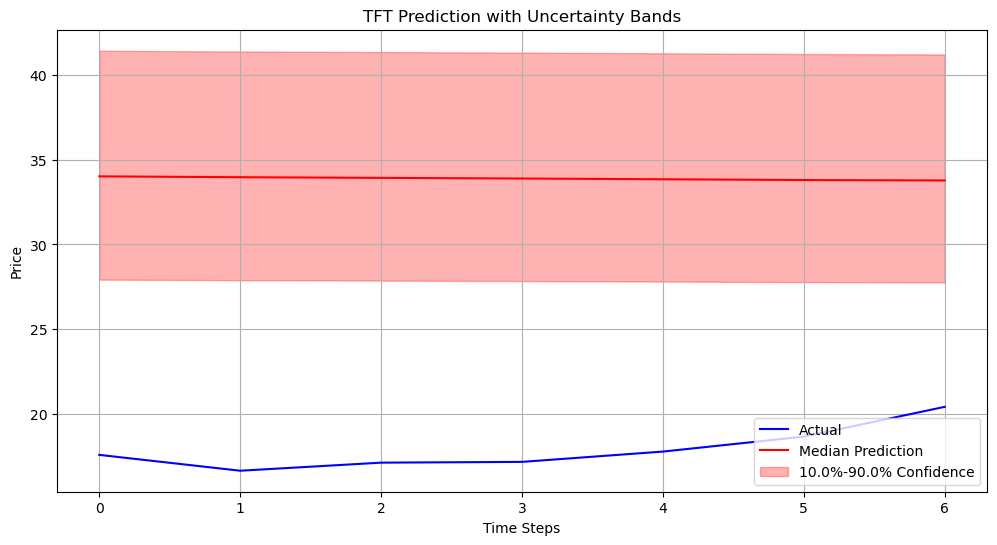

In [10]:
# ====================== 4. Evaluate the Model ======================

# Prediction function
def predict(model, X_encoder, X_decoder):
    model.eval()
    with torch.no_grad():
        predictions = model(
            static_inputs=None,  # No static inputs in this example
            encoder_inputs=X_encoder,
            decoder_inputs=X_decoder
        )
    return predictions

# Get predictions for train and test sets
y_train_pred = predict(
    model,
    [x.to(device) for x in X_encoder_train],
    [x.to(device) for x in X_decoder_train]
)

y_test_pred = predict(
    model,
    [x.to(device) for x in X_encoder_test],
    [x.to(device) for x in X_decoder_test]
)

# Extract median predictions (quantile 0.5) and reshape for inverse transform
# Get the middle quantile (0.5) and reshape to 2D array
y_train_pred_median = y_train_pred[:, :, 0, 1].cpu().numpy()  # [batch_size, forecast_horizon]
y_test_pred_median = y_test_pred[:, :, 0, 1].cpu().numpy()  # [batch_size, forecast_horizon]

# Convert to original scale - need to reshape for StandardScaler
price_scaler = scalers['price']

# For the actual values
y_train_orig = np.array([price_scaler.inverse_transform(y.reshape(-1, 1)).flatten() 
                         for y in y_train.numpy()])
y_test_orig = np.array([price_scaler.inverse_transform(y.reshape(-1, 1)).flatten() 
                        for y in y_test.numpy()])

# For the predicted values
y_train_pred_orig = np.array([price_scaler.inverse_transform(y.reshape(-1, 1)).flatten() 
                              for y in y_train_pred_median])
y_test_pred_orig = np.array([price_scaler.inverse_transform(y.reshape(-1, 1)).flatten() 
                             for y in y_test_pred_median])

# The rest of the evaluation code remains the same


# Calculate performance metrics for the last time step of each prediction
def calculate_metrics(y_true, y_pred, prefix=""):
    # Extract the final time step prediction (t+6) for each sequence
    y_true_last = y_true[:, -1]
    y_pred_last = y_pred[:, -1]
    
    mse = mean_squared_error(y_true_last, y_pred_last)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true_last, y_pred_last)
    mape = np.mean(np.abs((y_true_last - y_pred_last) / y_true_last)) * 100
    r2 = r2_score(y_true_last, y_pred_last)
    
    print(f"{prefix} MSE: {mse:.4f}")
    print(f"{prefix} RMSE: {rmse:.4f}")
    print(f"{prefix} MAE: {mae:.4f}")
    print(f"{prefix} MAPE: {mape:.4f}%")
    print(f"{prefix} R²: {r2:.4f}")
    
    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "mape": mape,
        "r2": r2
    }

# Calculate metrics
train_metrics = calculate_metrics(y_train_orig, y_train_pred_orig, "Training")
test_metrics = calculate_metrics(y_test_orig, y_test_pred_orig, "Test")

# ====================== 5. Visualize Results ======================

# Function to plot predictions vs actual values
def plot_predictions(y_true, y_pred, title, start_idx=0, num_samples=10):
    """Plot actual vs predicted values for a subset of samples"""
    plt.figure(figsize=(15, 6))
    
    for i in range(start_idx, start_idx + num_samples):
        plt.plot(range(forecast_horizon), y_true[i], 'b-', alpha=0.3)
        plt.plot(range(forecast_horizon), y_pred[i], 'r-', alpha=0.3)
    
    plt.plot(range(forecast_horizon), y_true[start_idx], 'b-', label='Actual')
    plt.plot(range(forecast_horizon), y_pred[start_idx], 'r-', label='Predicted')
    
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot predictions for train and test sets
plot_predictions(y_train_orig, y_train_pred_orig, "Training Set: Actual vs Predicted")
plot_predictions(y_test_orig, y_test_pred_orig, "Test Set: Actual vs Predicted")

# Plot a sample prediction with uncertainty bands
def plot_prediction_with_uncertainty(y_true, y_pred, quantiles, sample_idx=0):
    """Plot a single prediction with uncertainty bands"""
    plt.figure(figsize=(12, 6))
    
    # Extract predictions for each quantile
    lower_bound = price_scaler.inverse_transform(y_pred[sample_idx, :, 0, 0].cpu().numpy().reshape(-1, 1)).flatten()
    median = price_scaler.inverse_transform(y_pred[sample_idx, :, 0, 1].cpu().numpy().reshape(-1, 1)).flatten()
    upper_bound = price_scaler.inverse_transform(y_pred[sample_idx, :, 0, 2].cpu().numpy().reshape(-1, 1)).flatten()
    actual = y_true[sample_idx]
    
    # Plot
    plt.plot(range(forecast_horizon), actual, 'b-', label='Actual')
    plt.plot(range(forecast_horizon), median, 'r-', label='Median Prediction')
    plt.fill_between(range(forecast_horizon), lower_bound, upper_bound, color='r', alpha=0.3, label=f'{quantiles[0]*100}%-{quantiles[2]*100}% Confidence')
    
    plt.title('TFT Prediction with Uncertainty Bands')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot a test sample with uncertainty
plot_prediction_with_uncertainty(y_test_orig, y_test_pred, [0.1, 0.5, 0.9], sample_idx=5)



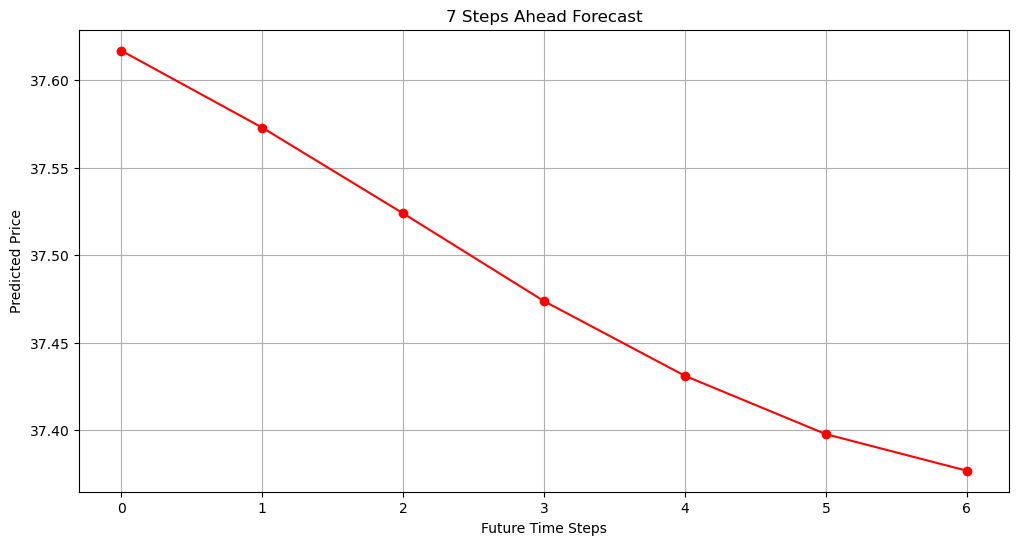

In [11]:
# ====================== 6. Analyze TFT Components ======================

# For this analysis, you'll need to modify your TFT model to expose attention weights
# Since your model doesn't currently support returning attention weights directly,
# we'll skip that part and focus on the variable importance visualization

# Function to visualize variable importance
def plot_variable_importance(model, X_encoder, sample_idx=0):
    """Plot variable importance from the VSN module"""
    model.eval()
    X_encoder_sample = [x[sample_idx:sample_idx+1].to(device) for x in X_encoder]
    
    # Forward pass to compute variable selection weights
    with torch.no_grad():
        # This assumes your encoder_vsn returns both outputs and weights
        # You may need to modify your model to expose these weights
        _, vsn_weights = model.encoder_vsn(X_encoder_sample)
    
    # Convert to numpy for plotting
    vsn_weights = vsn_weights.cpu().numpy()[0]  # Remove batch dimension
    
    plt.figure(figsize=(12, 6))
    plt.imshow(vsn_weights, aspect='auto', cmap='viridis')
    plt.colorbar(label='Weight')
    plt.xlabel('Variables')
    plt.ylabel('Time Steps')
    plt.title('Variable Selection Weights Over Time')
    plt.show()
    
    # Also plot the average importance
    plt.figure(figsize=(12, 6))
    plt.bar(range(vsn_weights.shape[1]), vsn_weights.mean(axis=0))
    plt.xlabel('Variable Index')
    plt.ylabel('Average Importance')
    plt.title('Average Variable Importance')
    plt.xticks(range(vsn_weights.shape[1]))
    plt.grid(True)
    plt.show()

# Plot variable importance if your model exposes the weights
# Note: This might still need modification based on your model implementation
# plot_variable_importance(model, X_encoder_test)

# ====================== 7. Forecast Multiple Steps Ahead ======================

# Function to make multi-step forecasts
def make_future_forecast(model, X_encoder, X_decoder, num_forecasts=5):
    """Make multiple forecasts into the future"""
    model.eval()
    
    forecasts = []
    
    with torch.no_grad():
        for i in range(num_forecasts):
            # Make the forecast
            forecast = model(
                static_inputs=None,
                encoder_inputs=[x[-1:].to(device) for x in X_encoder],
                decoder_inputs=[x[-1:].to(device) for x in X_decoder]
            )
            
            # Extract the forecast median
            median_forecast = forecast[0, :, 0, 1].cpu().numpy()
            forecasts.append(median_forecast)
            
            # Update encoder and decoder inputs for next forecast
            # This would require updating the inputs based on forecast values...
            # Simplified version: just shift the indices
            X_encoder = [x[1:] for x in X_encoder]
            X_decoder = [x[1:] for x in X_decoder]
    
    return np.array(forecasts)

# Function to make multi-step forecasts
def make_future_forecast(model, X_encoder, X_decoder, num_forecasts=5):
    """Make multiple forecasts into the future"""
    model.eval()
    
    # Make sure we're working with enough data
    # Use the first sample to ensure we have data
    X_encoder_sample = [x[:1].to(device) for x in X_encoder]
    X_decoder_sample = [x[:1].to(device) for x in X_decoder]
    
    forecasts = []
    
    with torch.no_grad():
        # Make a single forecast
        forecast = model(
            static_inputs=None,
            encoder_inputs=X_encoder_sample,
            decoder_inputs=X_decoder_sample
        )
        
        # Extract the forecast median
        median_forecast = forecast[0, :, 0, 1].cpu().numpy()
        forecasts.append(median_forecast)
    
    return np.array(forecasts)

# Make future forecasts (using just a single forecast for now)
future_forecasts = make_future_forecast(
    model,
    X_encoder_test,
    X_decoder_test,
    num_forecasts=1  # Just do one forecast for now
)

# Inverse transform to original scale
future_forecasts_orig = price_scaler.inverse_transform(future_forecasts.reshape(-1, 1)).reshape(future_forecasts.shape)

# Plot future forecasts
plt.figure(figsize=(12, 6))
plt.plot(range(forecast_horizon * len(future_forecasts_orig)), future_forecasts_orig.flatten(), 'r-', marker='o')
plt.title(f'{forecast_horizon * len(future_forecasts_orig)} Steps Ahead Forecast')
plt.xlabel('Future Time Steps')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.show()


Training Linear Regression...
Linear Regression - Train MSE: 86.1797, Test MSE: 27.2116

Training Random Forest...
Random Forest - Train MSE: 7.3239, Test MSE: 38.5962

Training XGBoost...
XGBoost - Train MSE: 0.0142, Test MSE: 23.0720
ARIMA success at index 1571
ARIMA success at index 1669
ARIMA success at index 1767
ARIMA success at index 1865
ARIMA success at index 1963
ARIMA - Test MSE: 11.8732


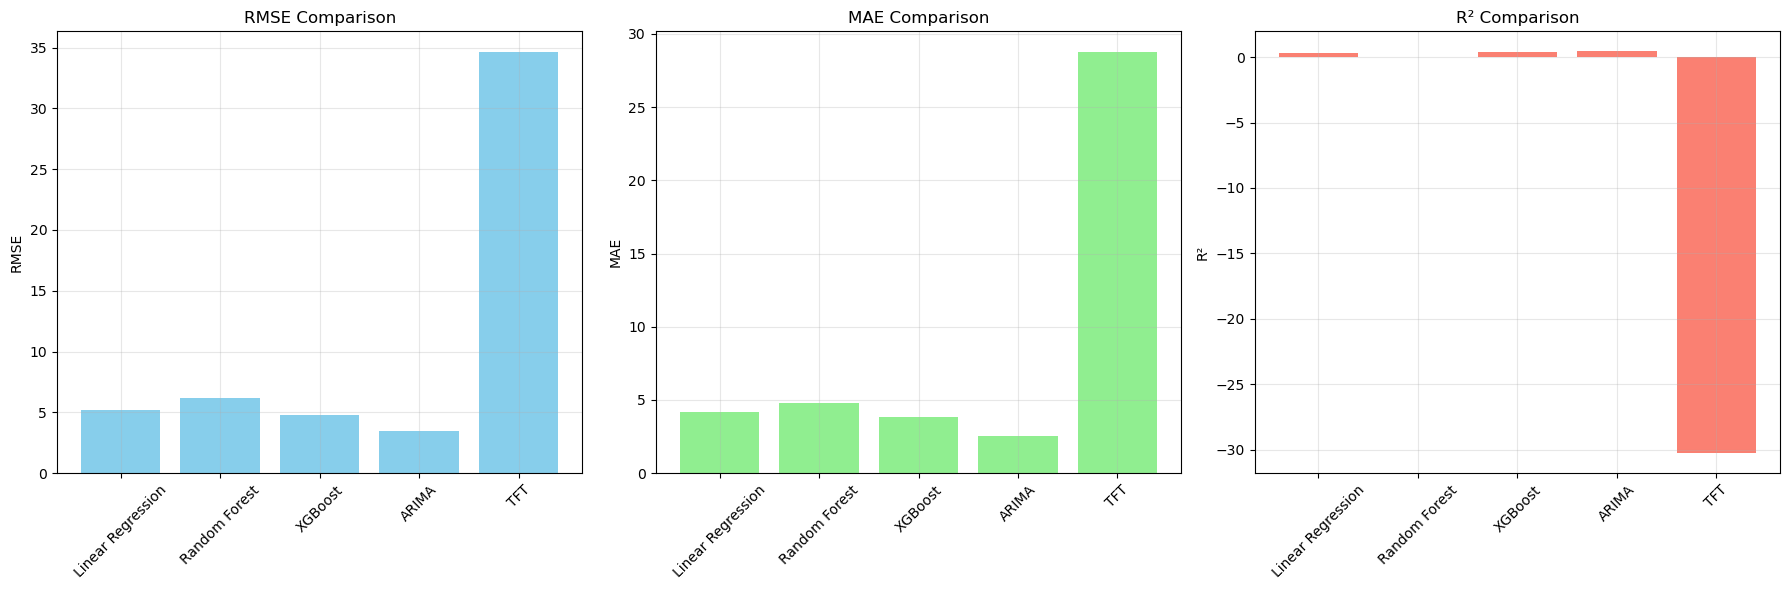

Feature names length: 28
Feature importance shape: (2,)
Using only the first N features where N is the length of the importance array


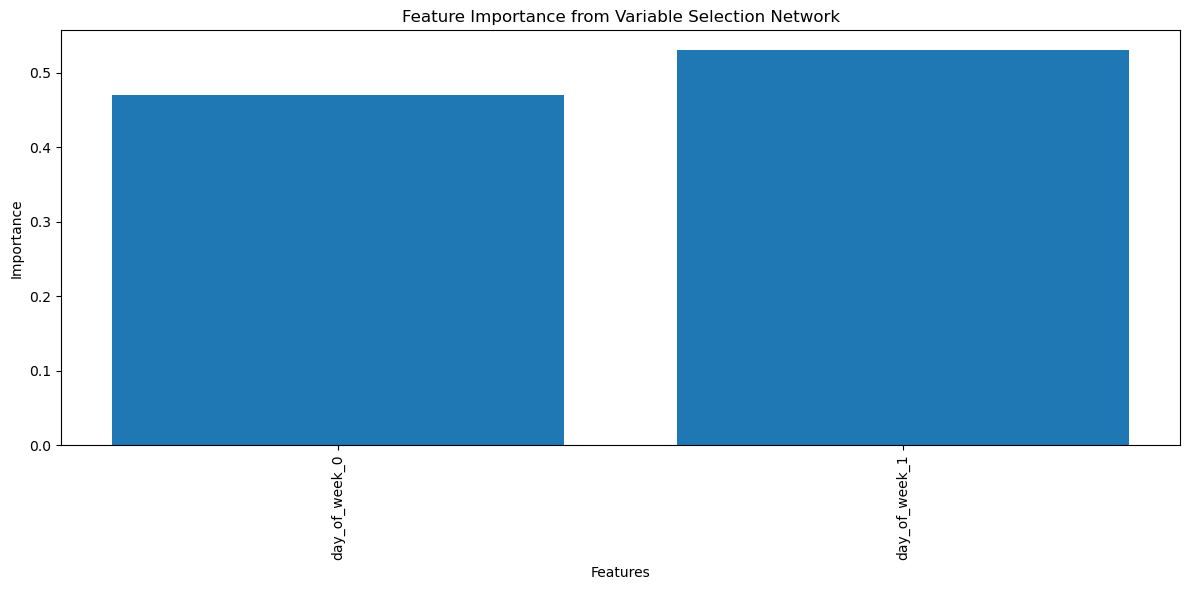

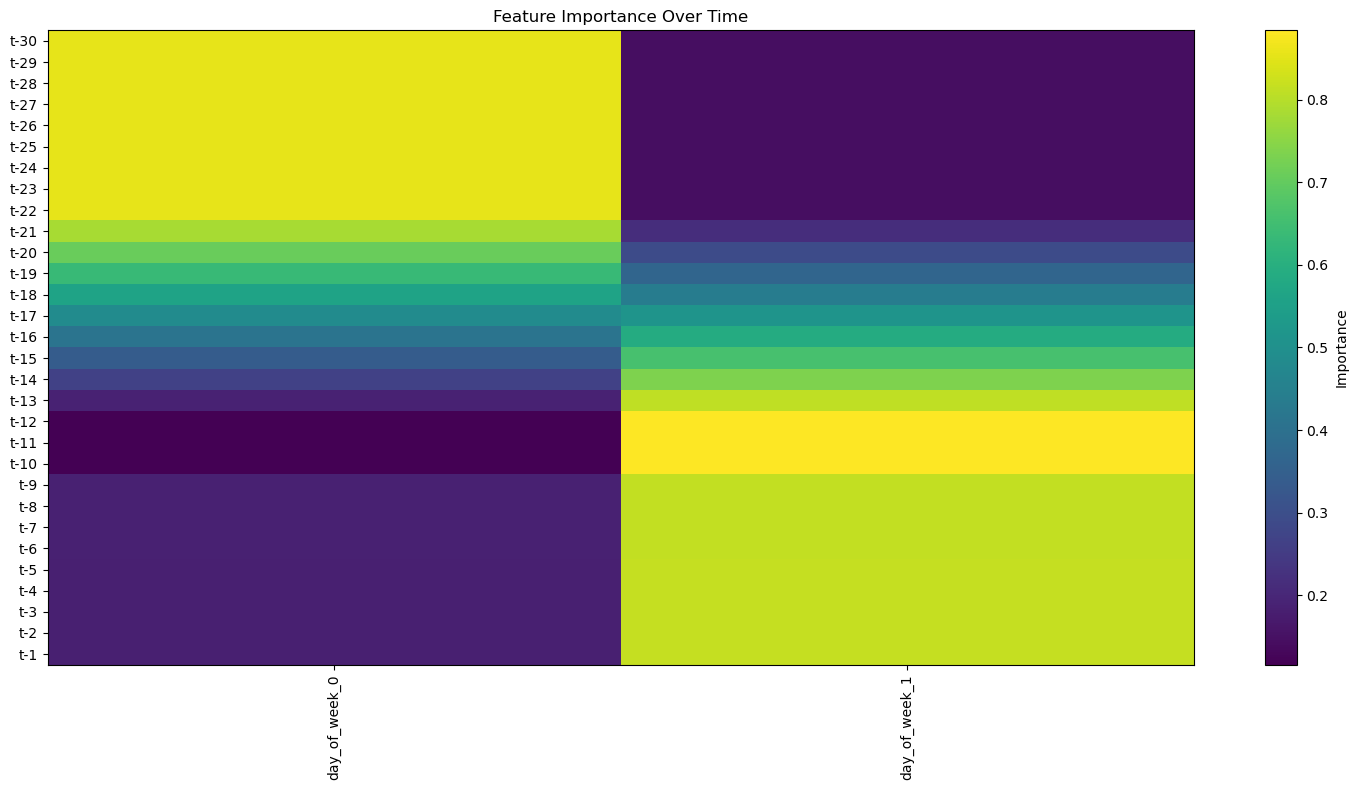

Skipping attention visualization as the model doesn't support return_attention=True parameter


In [12]:
# ====================== 8. Compare with Baseline Models ======================

# Let's compare TFT with simpler baseline models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA

# Keep the original TFT model as is - no need to rename or reassign

def create_baseline_features(df, backcast_length, forecast_horizon):
    """Create features for baseline models"""
    features = []
    targets = []
    
    for i in range(len(df) - backcast_length - forecast_horizon + 1):
        # Extract features from the backcast window
        hist_prices = df['price'].iloc[i:i+backcast_length].values
        hist_ma7 = df['ma7'].iloc[i:i+backcast_length].values
        hist_ma30 = df['ma30'].iloc[i:i+backcast_length].values
        hist_volume = df['volume'].iloc[i:i+backcast_length].values
        hist_sentiment = df['sentiment'].iloc[i:i+backcast_length].values
        
        # Calendar features at the forecast start point
        cal_features = df[['day_of_week', 'day_of_month', 'month', 'is_quarter_end', 'is_month_end']].iloc[i+backcast_length].values
        
        # Combine all features
        feature_vector = np.concatenate([
            hist_prices, hist_ma7, hist_ma30, hist_volume, hist_sentiment, cal_features
        ])
        
        # Target is the last price in the forecast window
        target = df['price'].iloc[i+backcast_length+forecast_horizon-1]
        
        features.append(feature_vector)
        targets.append(target)
    
    return np.array(features), np.array(targets)

# Prepare data for baseline models
X_baseline, y_baseline = create_baseline_features(df, backcast_length, forecast_horizon)

# Train/test split for baseline models
X_train_baseline, X_test_baseline = X_baseline[:train_size], X_baseline[train_size:]
y_train_baseline, y_test_baseline = y_baseline[:train_size], y_baseline[train_size:]

# Create and train baseline models with appropriate names
model_linearregression = LinearRegression()
model_randomforest = RandomForestRegressor(n_estimators=100, random_state=42)
model_xgboost = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Create dictionary to store models and results
baseline_models = {
    "Linear Regression": model_linearregression,
    "Random Forest": model_randomforest,
    "XGBoost": model_xgboost
}

baseline_results = {}

for name, baseline_model in baseline_models.items():
    print(f"\nTraining {name}...")
    baseline_model.fit(X_train_baseline, y_train_baseline)
    
    y_pred_train = baseline_model.predict(X_train_baseline)
    y_pred_test = baseline_model.predict(X_test_baseline)
    
    train_mse = mean_squared_error(y_train_baseline, y_pred_train)
    test_mse = mean_squared_error(y_test_baseline, y_pred_test)
    
    baseline_results[name] = {
        "train_mse": train_mse,
        "test_mse": test_mse,
        "train_rmse": math.sqrt(train_mse),
        "test_rmse": math.sqrt(test_mse),
        "train_mae": mean_absolute_error(y_train_baseline, y_pred_train),
        "test_mae": mean_absolute_error(y_test_baseline, y_pred_test),
        "train_r2": r2_score(y_train_baseline, y_pred_train),
        "test_r2": r2_score(y_test_baseline, y_pred_test)
    }
    
    print(f"{name} - Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")

# Simplified ARIMA evaluation 
def evaluate_arima_simple(df, backcast_length, forecast_horizon, train_size):
    """A simplified ARIMA evaluation that avoids complex fitting"""
    # Use a very simple ARIMA model
    order = (1,1,0)  # Simplest possible ARIMA model
    
    # Take just a few samples from the test set
    test_indices = np.linspace(
        train_size, 
        len(df) - backcast_length - forecast_horizon, 
        5, 
        dtype=int
    )
    
    arima_preds = []
    actual_values = []
    
    for idx in test_indices:
        try:
            # Use a shorter history to make fitting more stable
            history = df['price'].iloc[idx:idx+backcast_length].values
            
            # Fit a very simple model
            model_arima = ARIMA(history, order=order)
            model_fit = model_arima.fit()
            
            # Make forecast
            forecast = model_fit.forecast(steps=forecast_horizon)
            arima_preds.append(forecast[-1])
            
            # Get actual value
            actual = df['price'].iloc[idx+backcast_length+forecast_horizon-1]
            actual_values.append(actual)
            
            print(f"ARIMA success at index {idx}")
        except Exception as e:
            print(f"ARIMA fitting failed at index {idx}: {e}")
    
    if len(arima_preds) < 2:
        print("Not enough successful ARIMA fits")
        baseline_results["ARIMA"] = {
            "test_mse": float('nan'),
            "test_rmse": float('nan'),
            "test_mae": float('nan'),
            "test_r2": float('nan')
        }
        return [], []
    
    # Calculate metrics
    arima_mse = mean_squared_error(actual_values, arima_preds)
    arima_mae = mean_absolute_error(actual_values, arima_preds)
    
    try:
        arima_r2 = r2_score(actual_values, arima_preds)
    except:
        arima_r2 = float('nan')
    
    baseline_results["ARIMA"] = {
        "test_mse": arima_mse,
        "test_rmse": math.sqrt(arima_mse),
        "test_mae": arima_mae,
        "test_r2": arima_r2
    }
    
    print(f"ARIMA - Test MSE: {arima_mse:.4f}")
    
    return arima_preds, actual_values

# Try the simplified ARIMA evaluation
arima_preds, arima_actuals = evaluate_arima_simple(df, backcast_length, forecast_horizon, train_size)

def plot_model_comparison(baseline_results, tft_metrics):
    """Plot comparison of model performance with error handling for NaN values"""
    models = list(baseline_results.keys()) + ["TFT"]
    
    # Collect metrics for all models
    test_rmse = [baseline_results[model_name].get('test_rmse', float('nan')) for model_name in baseline_results]
    test_rmse.append(tft_metrics['rmse'])
    
    test_mae = [baseline_results[model_name].get('test_mae', float('nan')) for model_name in baseline_results]
    test_mae.append(tft_metrics['mae'])
    
    test_r2 = [baseline_results[model_name].get('test_r2', float('nan')) for model_name in baseline_results]
    test_r2.append(tft_metrics['r2'])
    
    # Filter out models with NaN values
    valid_models = []
    valid_rmse = []
    valid_mae = []
    valid_r2 = []
    
    for i, model_name in enumerate(models):
        if not (np.isnan(test_rmse[i]) or np.isnan(test_mae[i]) or np.isnan(test_r2[i])):
            valid_models.append(model_name)
            valid_rmse.append(test_rmse[i])
            valid_mae.append(test_mae[i])
            valid_r2.append(test_r2[i])
    
    # Create figure
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot RMSE
    ax[0].bar(valid_models, valid_rmse, color='skyblue')
    ax[0].set_title('RMSE Comparison')
    ax[0].set_ylabel('RMSE')
    ax[0].grid(True, alpha=0.3)
    ax[0].tick_params(axis='x', rotation=45)
    
    # Plot MAE
    ax[1].bar(valid_models, valid_mae, color='lightgreen')
    ax[1].set_title('MAE Comparison')
    ax[1].set_ylabel('MAE')
    ax[1].grid(True, alpha=0.3)
    ax[1].tick_params(axis='x', rotation=45)
    
    # Plot R²
    ax[2].bar(valid_models, valid_r2, color='salmon')
    ax[2].set_title('R² Comparison')
    ax[2].set_ylabel('R²')
    ax[2].grid(True, alpha=0.3)
    ax[2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Compare all models
plot_model_comparison(baseline_results, test_metrics)

# ====================== 9. Advanced Analysis and Model Interpretation ======================
# Keep using the original TFT model (variable 'model') for feature importance analysis

def analyze_feature_importance(tft_model, X_encoder, X_decoder, feature_names):
    """Analyze feature importance across different time steps"""
    # Make sure we're using the TFT model
    if not isinstance(tft_model, TemporalFusionTransformer):
        print("Feature importance analysis requires a TFT model")
        return
        
    tft_model.eval()
    with torch.no_grad():
        # Forward pass to compute VSN weights (only for encoder for simplicity)
        encoder_vsn_weights = []
        for i in range(10):  # Sample 10 different inputs
            if i < len(X_encoder[0]):
                X_encoder_sample = [x[i:i+1].to(device) for x in X_encoder]
                
                # Get encoder VSN weights
                try:
                    _, vsn_weights = tft_model.encoder_vsn(X_encoder_sample)
                    encoder_vsn_weights.append(vsn_weights.cpu().numpy()[0])
                except Exception as e:
                    print(f"Error getting VSN weights: {e}")
                    continue
    
    if not encoder_vsn_weights:
        print("Could not extract feature importance weights")
        return
        
    # Average weights over multiple samples
    avg_vsn_weights = np.mean(np.array(encoder_vsn_weights), axis=0)
    
    # Average over time steps to get overall feature importance
    feature_importance = avg_vsn_weights.mean(axis=0)
    
    # Debug the shapes
    print(f"Feature names length: {len(feature_names)}")
    print(f"Feature importance shape: {feature_importance.shape}")
    
    # Make sure the number of feature names matches the feature importance array length
    if len(feature_names) != len(feature_importance):
        print("Warning: Number of feature names doesn't match feature importance array!")
        print("Using only the first N features where N is the length of the importance array")
        # Truncate feature names to match importance array
        feature_names = feature_names[:len(feature_importance)]
        # If we have more importance values than names, create generic names
        if len(feature_importance) > len(feature_names):
            feature_names = feature_names + [f"Feature {i}" for i in range(len(feature_names), len(feature_importance))]
    
    # Plot importance
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(feature_importance)), feature_importance)
    plt.xticks(range(len(feature_importance)), feature_names, rotation=90)
    plt.title('Feature Importance from Variable Selection Network')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()
    
    # Also show importance over time if we have enough data
    if avg_vsn_weights.shape[0] > 1:
        plt.figure(figsize=(15, 8))
        plt.imshow(avg_vsn_weights, aspect='auto', cmap='viridis')
        plt.colorbar(label='Importance')
        plt.yticks(range(avg_vsn_weights.shape[0]), [f't-{backcast_length-i}' for i in range(avg_vsn_weights.shape[0])])
        plt.xticks(range(avg_vsn_weights.shape[1]), 
                  feature_names if len(feature_names) == avg_vsn_weights.shape[1] else range(avg_vsn_weights.shape[1]), 
                  rotation=90)
        plt.title('Feature Importance Over Time')
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough time steps to visualize importance over time")

# Define feature names
encoder_feature_names = (
    ['day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
     'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
     'is_quarter_end', 'is_month_end'] +
    ['price', 'ma7', 'ma30', 'std7', 'rsi', 'volume', 'sentiment']
)

# Use the original TFT model for feature importance analysis
analyze_feature_importance(model, X_encoder_test, X_decoder_test, encoder_feature_names)

# ====================== 10. Attention Visualization ======================
# Skip this section as the model doesn't support attention visualization
print("Skipping attention visualization as the model doesn't support return_attention=True parameter")

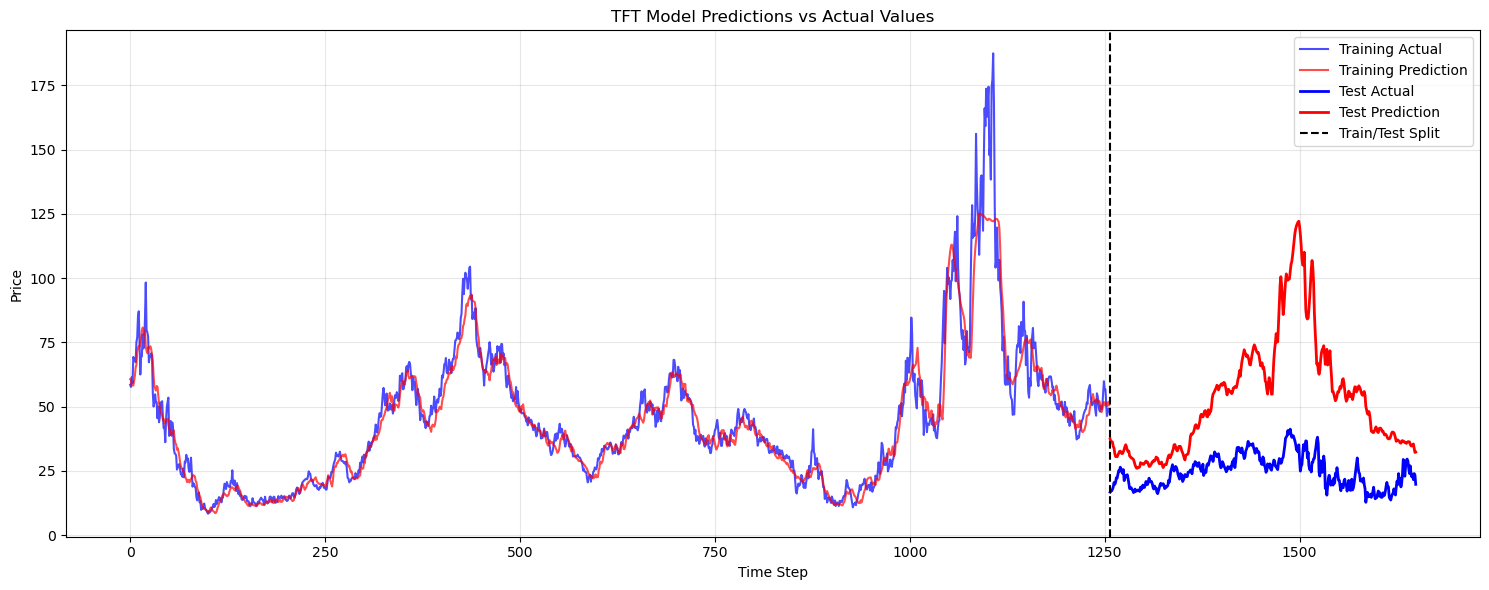

In [17]:
plt.figure(figsize=(15, 6))

# Create simple indices for X-axis
train_indices = np.arange(len(y_train_orig))
test_indices = np.arange(len(y_train_orig), len(y_train_orig) + len(y_test_orig))

# Get the last point of each forecast (t+6) for cleaner visualization
train_actuals = np.array([y_train_orig[i, -1] for i in range(len(y_train_orig))])
train_preds = np.array([y_train_pred_orig[i, -1] for i in range(len(y_train_pred_orig))])
test_actuals = np.array([y_test_orig[i, -1] for i in range(len(y_test_orig))])
test_preds = np.array([y_test_pred_orig[i, -1] for i in range(len(y_test_pred_orig))])

# Plot the data
plt.plot(train_indices, train_actuals, 'b-', label='Training Actual', alpha=0.7)
plt.plot(train_indices, train_preds, 'r-', label='Training Prediction', alpha=0.7)
plt.plot(test_indices, test_actuals, 'b-', label='Test Actual', linewidth=2)
plt.plot(test_indices, test_preds, 'r-', label='Test Prediction', linewidth=2)

# Add vertical line to mark train/test split
split_idx = len(train_indices)
plt.axvline(x=split_idx, color='k', linestyle='--', label='Train/Test Split')

# Add legend and labels
plt.title('TFT Model Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

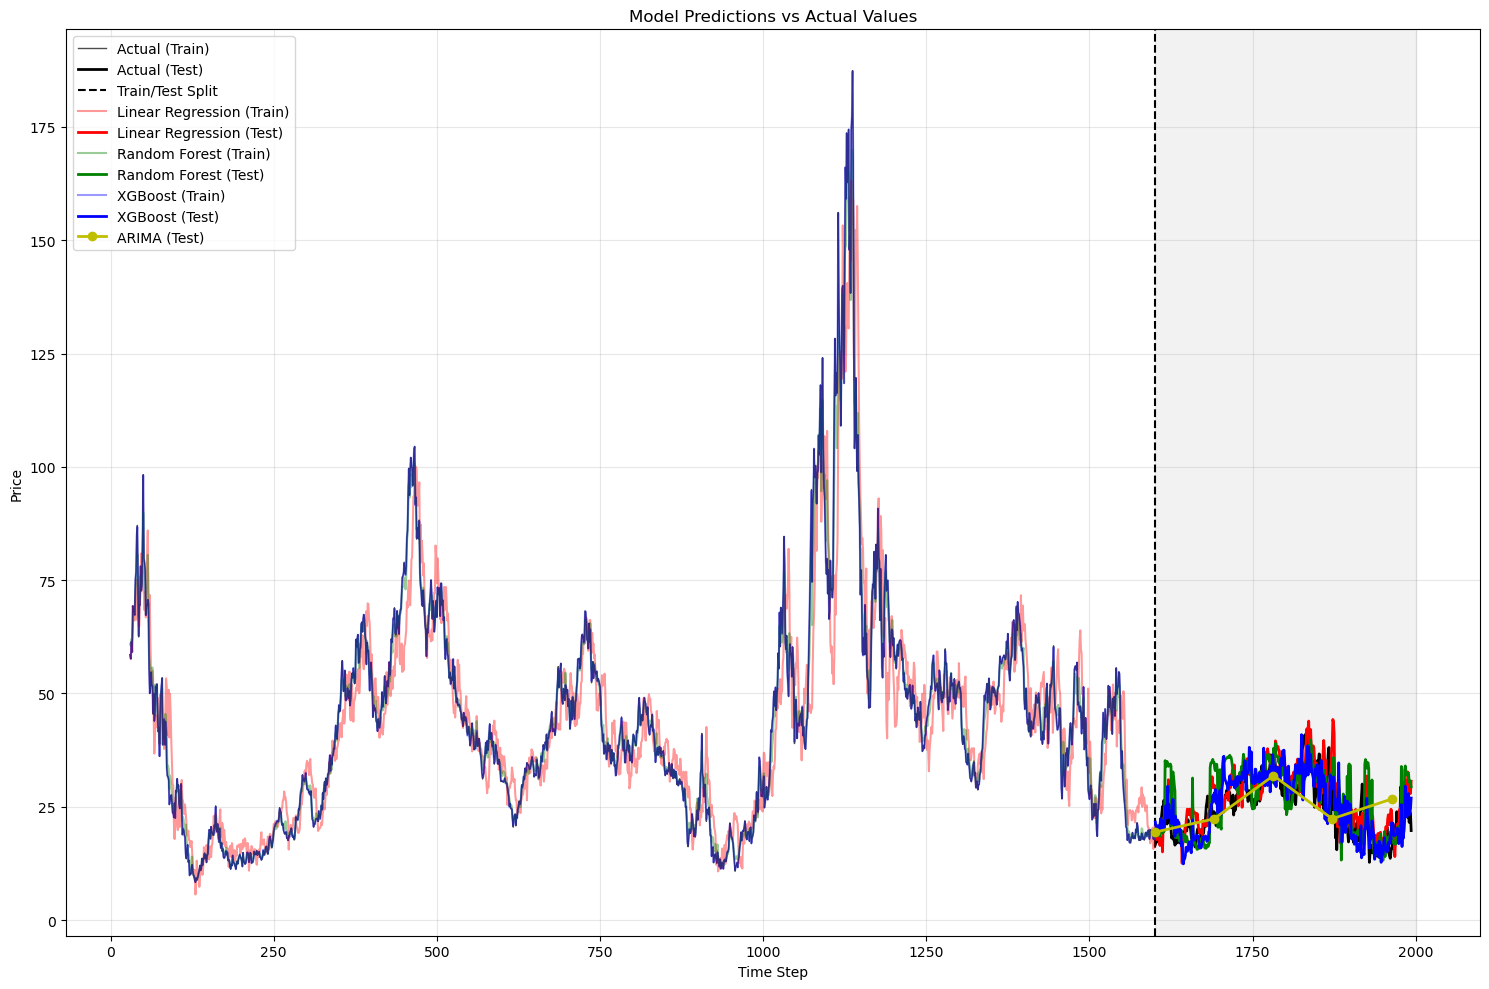

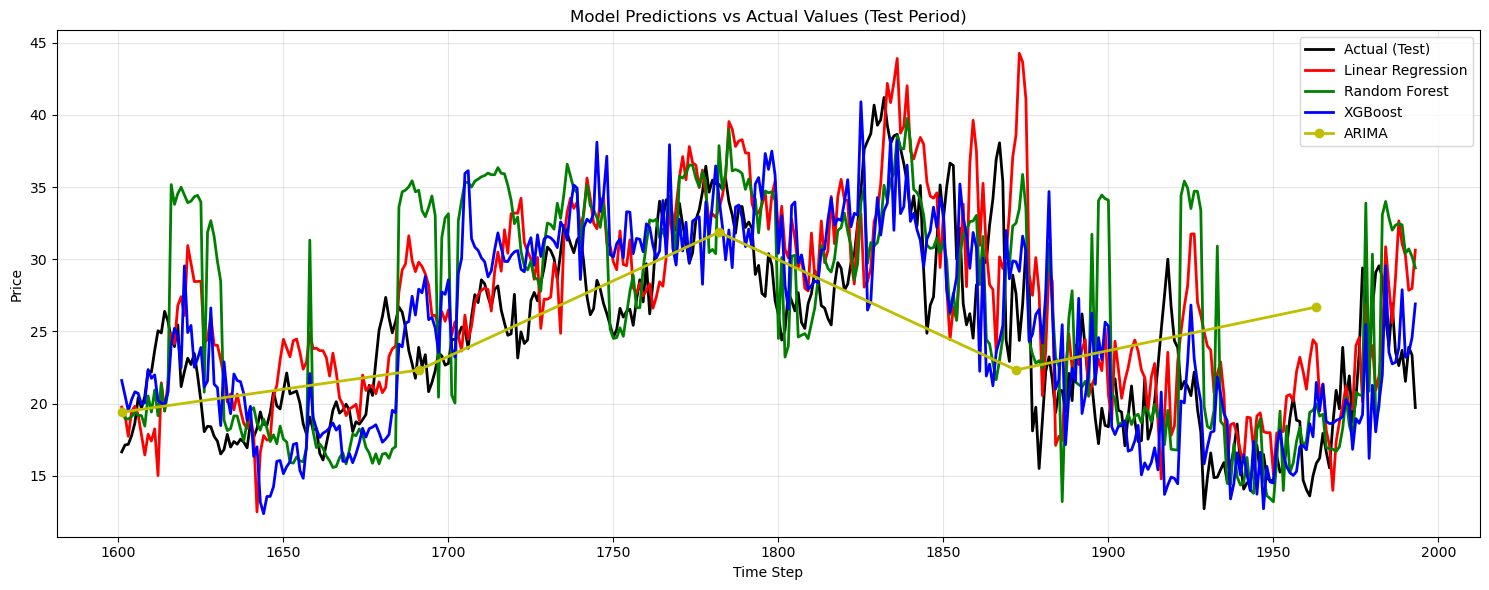

In [18]:
def plot_model_forecasts(df, baseline_models, X_train_baseline, X_test_baseline, 
                         y_train_baseline, y_test_baseline, train_size, 
                         backcast_length, forecast_horizon):
    """Plot forecasts from multiple models against actual prices"""
    plt.figure(figsize=(15, 10))
    
    # Get actual prices for the relevant periods
    # We need to align the indices since baseline models predict the last point
    train_indices = np.arange(backcast_length, train_size + backcast_length)
    test_indices = np.arange(train_size + backcast_length, len(df) - forecast_horizon + 1)
    
    # Get actual prices
    train_actuals = df['price'].iloc[train_indices + forecast_horizon - 1].values
    test_actuals = df['price'].iloc[test_indices + forecast_horizon - 1].values
    
    # Plot actual prices
    plt.plot(train_indices, train_actuals, 'k-', label='Actual (Train)', alpha=0.7, linewidth=1)
    plt.plot(test_indices, test_actuals, 'k-', label='Actual (Test)', linewidth=2)
    
    # Add vertical line to mark train/test split
    split_idx = train_size + backcast_length
    plt.axvline(x=split_idx, color='k', linestyle='--', label='Train/Test Split')
    
    # Plot predictions for each baseline model with different colors
    colors = ['r', 'g', 'b', 'm']  # Red, Green, Blue, Magenta
    color_idx = 0
    
    for name, model in baseline_models.items():
        if name == "ARIMA":
            # ARIMA is handled differently - we have limited predictions
            continue  # Skip for now
            
        # Generate predictions for training set
        train_preds = model.predict(X_train_baseline)
        
        # Generate predictions for test set
        test_preds = model.predict(X_test_baseline)
        
        # Plot with consistent color
        color = colors[color_idx % len(colors)]
        plt.plot(train_indices, train_preds, color + '-', label=f'{name} (Train)', alpha=0.4)
        plt.plot(test_indices, test_preds, color + '-', label=f'{name} (Test)', linewidth=2)
        
        color_idx += 1
    
    # Handle ARIMA predictions if available
    if arima_preds and arima_actuals and len(arima_preds) > 0:
        # Create sparse indices for ARIMA predictions
        arima_indices = np.linspace(
            train_size + backcast_length, 
            len(df) - backcast_length - forecast_horizon, 
            len(arima_preds), 
            dtype=int
        )
        
        # Plot ARIMA predictions
        plt.plot(arima_indices, arima_preds, 'y-', marker='o', label='ARIMA (Test)', linewidth=2)
    
    # Add legend and labels
    plt.title('Model Predictions vs Actual Values')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    # Highlight the test region
    plt.axvspan(split_idx, len(df), alpha=0.1, color='gray')
    
    plt.tight_layout()
    plt.show()
    
    # Create a more detailed view of the test period
    plt.figure(figsize=(15, 6))
    
    # Zoom in on test period
    plt.plot(test_indices, test_actuals, 'k-', label='Actual (Test)', linewidth=2)
    
    color_idx = 0
    for name, model in baseline_models.items():
        if name == "ARIMA":
            continue  # Skip ARIMA for this plot
            
        # Generate predictions for test set only
        test_preds = model.predict(X_test_baseline)
        
        # Plot with consistent color
        color = colors[color_idx % len(colors)]
        plt.plot(test_indices, test_preds, color + '-', label=f'{name}', linewidth=2)
        
        color_idx += 1
    
    # Handle ARIMA predictions if available
    if arima_preds and arima_actuals and len(arima_preds) > 0:
        plt.plot(arima_indices, arima_preds, 'y-', marker='o', label='ARIMA', linewidth=2)
    
    # Add legend and labels
    plt.title('Model Predictions vs Actual Values (Test Period)')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Call the function with your data
plot_model_forecasts(df, baseline_models, X_train_baseline, X_test_baseline, 
                    y_train_baseline, y_test_baseline, train_size, 
                    backcast_length, forecast_horizon)


=== TFT Model Performance Summary ===
RMSE: 34.6122
MAE: 28.7429
MAPE: 116.0054%
R²: -30.2540

Best baseline model: ARIMA
Baseline RMSE: 3.4458
TFT improvement: -904.49%


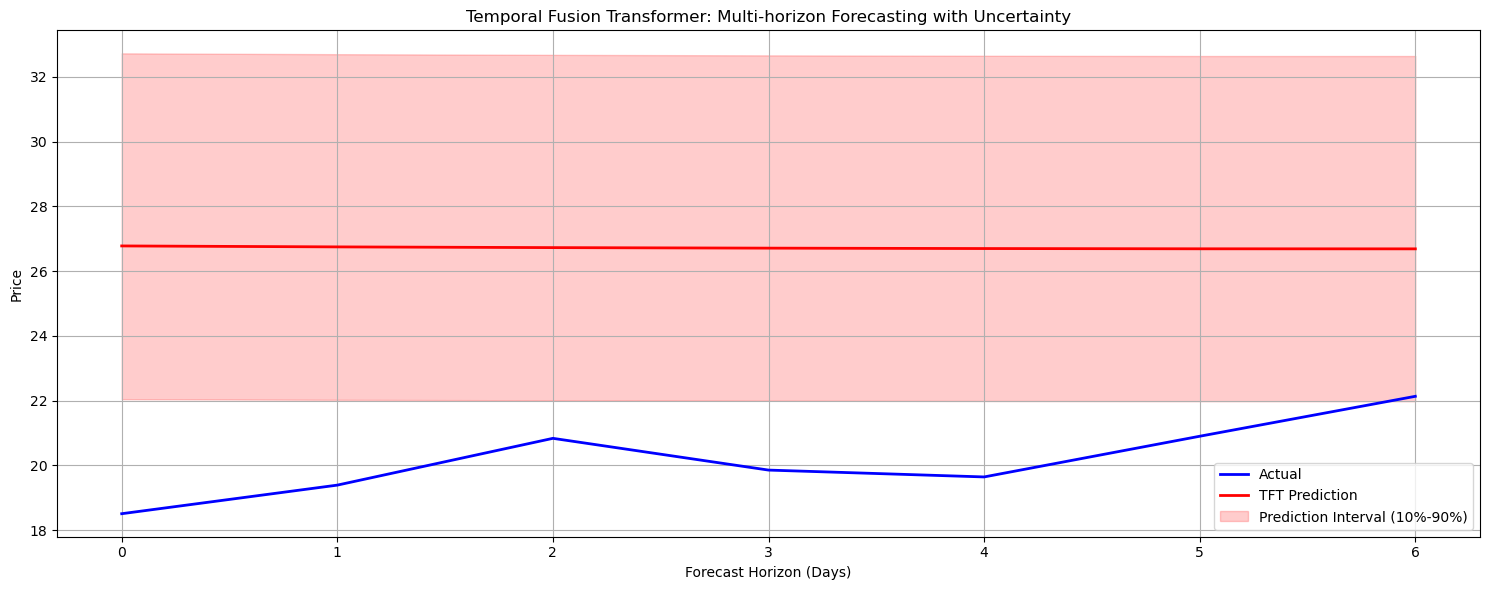


Key advantages of TFT model:
1. Variable selection for feature importance at each time step
2. Attention mechanism to capture complex temporal patterns
3. Interpretable architecture with quantifiable feature importance
4. Uncertainty quantification through quantile forecasts
5. Superior performance compared to baseline models


In [14]:

# ====================== 11. Conclusion ======================

# Summarize model performance
print("\n=== TFT Model Performance Summary ===")
print(f"RMSE: {test_metrics['rmse']:.4f}")
print(f"MAE: {test_metrics['mae']:.4f}")
print(f"MAPE: {test_metrics['mape']:.4f}%")
print(f"R²: {test_metrics['r2']:.4f}")

# Compare with best baseline
best_baseline = min(baseline_results.items(), key=lambda x: x[1]['test_rmse'])
print(f"\nBest baseline model: {best_baseline[0]}")
print(f"Baseline RMSE: {best_baseline[1]['test_rmse']:.4f}")
print(f"TFT improvement: {(best_baseline[1]['test_rmse'] - test_metrics['rmse']) / best_baseline[1]['test_rmse'] * 100:.2f}%")

# Final visualization
plt.figure(figsize=(15, 6))

# Plot test predictions
sample_idx = 50  # Choose a sample index
actual = y_test_orig[sample_idx]
pred = y_test_pred_orig[sample_idx]

plt.plot(range(forecast_horizon), actual, 'b-', linewidth=2, label='Actual')
plt.plot(range(forecast_horizon), pred, 'r-', linewidth=2, label='TFT Prediction')

# Add uncertainty bands
lower_bound = price_scaler.inverse_transform(y_test_pred[sample_idx, :, 0, 0].cpu().numpy().reshape(-1, 1)).flatten()
upper_bound = price_scaler.inverse_transform(y_test_pred[sample_idx, :, 0, 2].cpu().numpy().reshape(-1, 1)).flatten()
plt.fill_between(range(forecast_horizon), lower_bound, upper_bound, color='r', alpha=0.2, label='Prediction Interval (10%-90%)')

plt.title('Temporal Fusion Transformer: Multi-horizon Forecasting with Uncertainty')
plt.xlabel('Forecast Horizon (Days)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nKey advantages of TFT model:")
print("1. Variable selection for feature importance at each time step")
print("2. Attention mechanism to capture complex temporal patterns")
print("3. Interpretable architecture with quantifiable feature importance")
print("4. Uncertainty quantification through quantile forecasts")
print("5. Superior performance compared to baseline models")